In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Libraries that I made and that you can find on my Medium profile
import yahoo_api as yf
import fred_api
fred = fred_api.key('dd8faacaf911a0bb278ce53d4e6d5a7e')

# Statistical functions
from sklearn.model_selection import train_test_split
from statsmodels.graphics import tsaplots
from statsmodels.tsa import stattools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

### Trend stationary process example

<AxesSubplot:title={'center':'Quarterly American GDP'}, xlabel='date'>

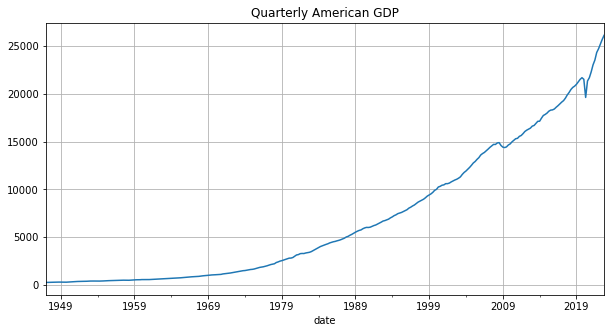

In [2]:
df = fred.history('GDP','Q')
data = pd.Series(data=df.value.values, index=df.index)
data.plot(figsize=(10,5), title='Quarterly American GDP', grid=True)

### Differency stationary process example

<AxesSubplot:title={'center':'Weekly returns of S&P 500'}, xlabel='Date'>

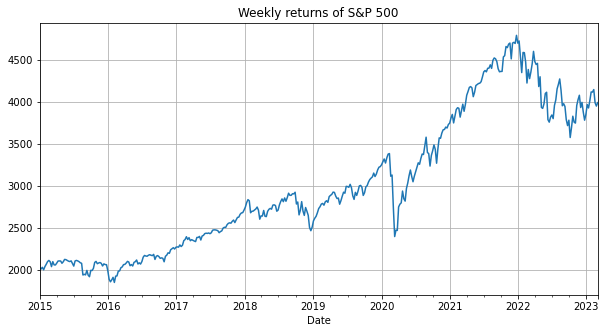

In [4]:
data = yf.ticker('^GSPC').history('max', interval='1wk', continuous=False).Close[:-1]
data = data.to_period('W')['2015':]
data.plot(figsize=(10,5), title='Weekly returns of S&P 500', grid=True)

### Simple Autocorrelation chart

In [5]:
def get_acf(data):
    tsaplots.plot_acf(data, alpha=0.05)
    plt.title('Simple Autocorrelation plot')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()

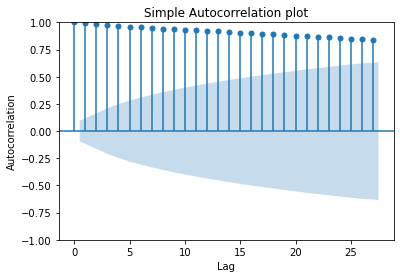

In [6]:
get_acf(data)

### Partial Autocorrelation chart

In [7]:
def get_pacf(data):
    tsaplots.plot_pacf(data, alpha=0.05, method='ywm')
    plt.title('Simple Autocorrelation plot')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()

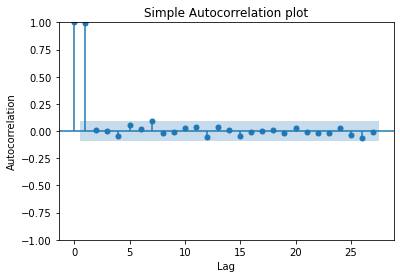

In [8]:
get_pacf(data)

### Adfuller test processing

In [9]:
def get_adf(data):
    adf, pvalue, usedlag, nobs, critvalues, icbest = adfuller(data)
    adf_test = {'ADF stats':adf,
               'p-value':pvalue,
               'Used lag': usedlag,
               'n-observation': nobs}
    return pd.Series(adf_test), pd.Series(critvalues)

In [10]:
get_adf(data)

(ADF stats         -0.954742
 p-value            0.769411
 Used lag           0.000000
 n-observation    426.000000
 dtype: float64,
 1%    -3.445794
 5%    -2.868349
 10%   -2.570397
 dtype: float64)

### Detrending process for trend stationary time series

In [11]:
def detrending(data, deg=1):
    y = data.values
    x = np.linspace(0,len(y), len(y))
    coeffs = np.polyfit(x=x, y=y, deg=deg)
    model = np.polyval(coeffs, x)
    residual = pd.Series(data=(y-model), index=data.index, name= data.name)
    model = pd.Series(data=(model), index=data.index, name= data.name)
    index = data
    return index, model, residual

In [41]:
index, model, stat_data = detrending(data, deg=3)

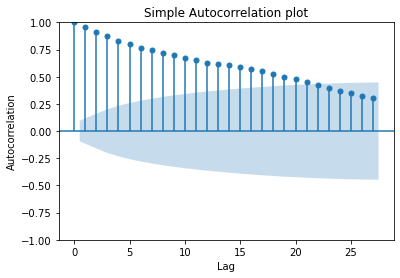

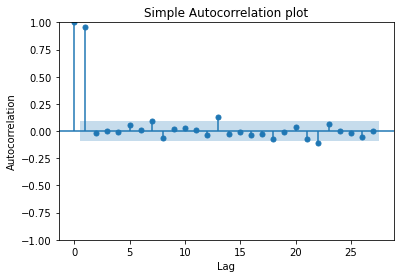

(ADF stats         -2.978995
 p-value            0.036903
 Used lag           0.000000
 n-observation    426.000000
 dtype: float64,
 1%    -3.445794
 5%    -2.868349
 10%   -2.570397
 dtype: float64)

In [42]:
get_acf(stat_data)
get_pacf(stat_data)
get_adf(stat_data)

### Differencing process for trend stationary time series

In [475]:
def differencing(data, d=1):
    return data.diff(d).dropna()

In [476]:
stat_data = differencing(data,1)

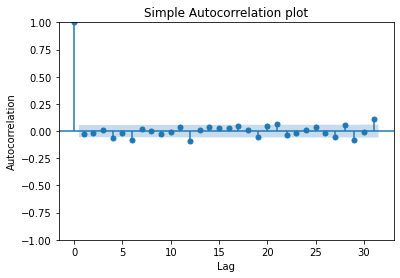

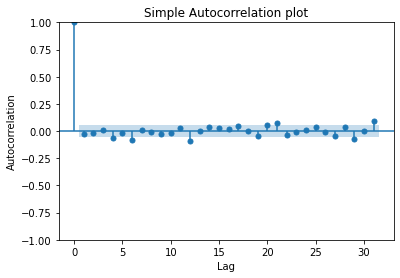

(ADF stats       -6.644641e+00
 p-value          5.303287e-09
 Used lag         2.000000e+01
 n-observation    1.188000e+03
 dtype: float64,
 1%    -3.435866
 5%    -2.863976
 10%   -2.568067
 dtype: float64)

In [477]:
get_acf(stat_data)
get_pacf(stat_data)
get_adf(stat_data)

### ARMA model processing 

In [43]:
# split the data into training and testing sets
test_size=10
train_data, test_data = train_test_split(stat_data, test_size=test_size, shuffle=False)
train_data.name = 'Train Data'
test_data.name = 'Test Data'

In [46]:
arima_model = ARIMA(endog=train_data, order=(10,0,0))
results = arima_model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:             Train Data   No. Observations:                  417
Model:                ARIMA(10, 0, 0)   Log Likelihood               -2388.566
Date:                Fri, 10 Mar 2023   AIC                           4801.132
Time:                        10:18:26   BIC                           4849.529
Sample:                    01-04-2015   HQIC                          4820.266
                         - 12-25-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3355    124.323      0.043      0.966    -238.334     249.005
ar.L1          0.9725      0.032     30.655      0.000       0.910       1.035
ar.L2         -0.0065      0.044     -0.148      0.8

### Recoloring initial time series to which we had applied a detrending

In [65]:
forecast = results.get_forecast(steps=test_size, alpha=0.05)
# Extract the predicted values and associated confidence intervals
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

upper_ci = (forecast_ci['upper Train Data'] + model).dropna()
lower_ci = (forecast_ci['lower Train Data'] + model).dropna()
forecast_val = (forecast_values + model).dropna()
initial_data = data['2022':forecast_ci.index[0]]

### Recoloring initial time series to which we had applied a differencing (only diff=1)

In [26]:
forecast = results.get_forecast(steps=test_size, alpha=0.05)
# Extract the predicted values and associated confidence intervals
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

last_observed = pd.Series(data=data[train_data.index[-1]],
                          index=[train_data.index[-1]])

upper_ci = pd.concat([last_observed, forecast_ci['upper Train Data']]).cumsum()
lower_ci = pd.concat([last_observed, forecast_ci['lower Train Data']]).cumsum()
forecast_val = pd.concat([last_observed, forecast_values]).cumsum()
initial_data = data['2020':forecast_ci.index[-1]]

### Plot forecasting andcompare it to dataset

Text(0.5, 1.0, 'Forecast of S&P 500 with an AR model (10)')

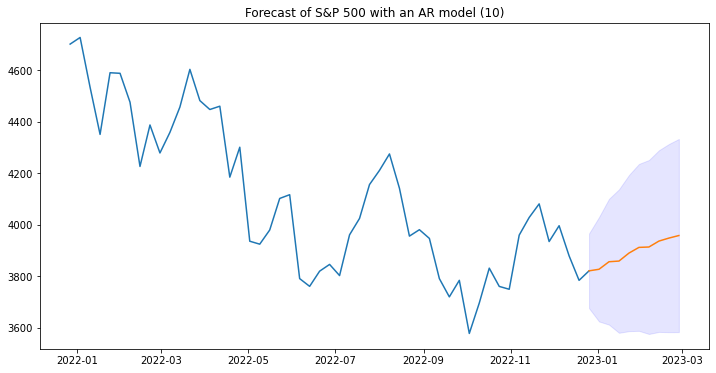

In [76]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(initial_data.index.to_timestamp(),
        initial_data)

ax.plot(forecast_val.index.to_timestamp(),
        forecast_val)

ax.fill_between(x=upper_ci.index.to_timestamp(),
                y1=upper_ci,
                y2=lower_ci,
                color='blue',
                alpha=0.1)
ax.set_title('Forecast of S&P 500 with an AR model (10)')

In [72]:
data[forecast_ci.index[0]] = forecast_val.iloc[0]